### Rephrase ERA5-fitted PySR equation in a physical way

In [26]:
import numpy as np
import sympy as sp

In [27]:
# Best TL2 coefficients from home/b/b309170/my_work/published_code/grundner23james_EquationDiscovery_CloudCover_addressing_reviews/sec5_results/sec53_transferability_to_era5/era5_1979-2021/era5_tuned_pysr_EQ4_mod.json
# In normalized space
[a, b, c, d, e, f, g, h, i, j] = [39.00553647200795, 42.03463110460265, 6.465638378846791, 2.261470694652524, \
                                  0.04262325503419716, 0.502986898449626, 31.168968461162308, 11.400469972670322, \
                                  0.6233673793100785, 0.7307425434498263]

In [28]:
# Where did those numbers come from (from mo_cover.f90)?

# ! ! These were tuned on ERA5 data and yield worse results online:
# ! ! Ensure dC/dRH >= 0 
# ! rh_norm = max(rh_norm, 1/(2.*6.465638378846791*2.261470694652524)*(-6.465638378846791*T_norm**2-39.00553647200795))
# ! !
# ! ! Compute the three terms in the equation
# ! I1 = 39.00553647200795*rh_norm - 42.03463110460265*T_norm + 6.465638378846791*rh_norm*(2.261470694652524*rh_norm + T_norm**2) + 31.168968461162308
# ! I2 = rh_z_norm**2*(0.04262325503419716*rh_z_norm + 0.502986898449626)
# ! I3 = 11.400469972670322/(qc_norm + 0.6233673793100785*qi_norm + 0.7307425434498263)

In [29]:
# Convert to physical form first!

all_possible_features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
            'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']

loc = {}

# Careful here; don't call i_loop just i!!! 
for i_loop in range(len(all_possible_features)):
    loc[all_possible_features[i_loop]] = i_loop
    
# Features
features = ['rh', 'ta', 'clw', 'cli', 'rh_z']
no_features = len(features)

# mean and std
mean_all = [4.12205844e-03,2.25493498e-05,3.38180032e-06,2.57065512e+02,6.00030443e+04,5.64080139e+03,2.35046400e-01,1.32776682e+01,6.02512234e-01,9.86270417e+04,-1.27545273e-06,-4.02484958e-10,1.65204582e-08,-4.34660202e-11,4.29441131e-10,-1.82817316e-12,-4.68742483e-03,-7.54899040e-07,-7.51544542e+00,-1.06989723e-04,1.65615172e-03,-9.27604679e-06,-4.76200071e-05,-1.32246548e-07]
std_all = [5.07648249e-03,5.69702638e-05,1.01308124e-05,3.00533874e+01,3.12514292e+04,5.66963918e+03,4.11184302e-01,1.11389888e+01,3.32494615e-01,6.24039256e+03,2.03179260e-06,1.17041141e-08,1.33311867e-07,1.42840744e-09,6.73384546e-09,5.07424672e-11,5.82875686e-03,6.34826092e-05,3.53136052e+00,1.13215264e-02,6.62892130e-03,6.08144307e-05,2.58065098e-04,2.49552692e-06]

mean = np.concatenate([np.expand_dims(mean_all[loc[sel_var]], axis=0) for sel_var in features], axis = 0)
std = np.concatenate([np.expand_dims(std_all[loc[sel_var]], axis=0) for sel_var in features], axis = 0)

# Introduce variables
# a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r = sp.symbols('a b c d e f g h i j k l m n o p q r')
# x0, x1, x2, x3, x4 = sp.symbols('x0 x1 x2 x3 x4')
rh, ta, clw, cli, rh_z = sp.symbols('rh ta clw cli rh_z')

X0 = (rh - mean[0])/std[0]
X1 = (ta - mean[1])/std[1]
X2 = (clw - mean[2])/std[2]
X3 = (cli - mean[3])/std[3]
X4 = (rh_z - mean[4])/std[4]

I1 = a*X0 - b*X1 + c*X0*(d*X0 + X1**2) + g
I2 = X4**2*(e*X4 + f)
I3 = -h/(X2 + i*X3 + j)

print('I1')
print(sp.expand(I1))

print('\nI2')
print(I2)

print('\nI3')
print(I3)

I1
132.26140850072*rh**2 + 0.0215297970401709*rh*ta**2 - 11.0691365987752*rh*ta + 1380.68018421355*rh - 0.0129719661122399*ta**2 + 5.27062488727963*ta - 489.172781480643

I2
15015557.2872681*(rh_z + 4.76200071e-5)**2*(165.164740852315*rh_z + 0.510852044581683)

I3
-11.4004699726703/(61531.8253558894*cli + 17553.0168424461*clw + 0.126845079945486)


In [32]:
# Translate the coefficients of these I1, I2, I3 into the old form
a1 = 132.26140850072
a2 = 0.0215297970401709
a3 = 0.0129719661122399
a4 = 11.0691365987752
a5 = 1380.68018421355
a6 = 5.27062488727963
a7 = 489.172781480643
a8 = 165.164740852315*15015557.2872681
a9 = 0.510852044581683*15015557.2872681
a10 = 17553.0168424461/11.4004699726703
a11 = 61531.8253558894/11.4004699726703
eps = 0.126845079945486/11.4004699726703

old_coef_form = [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, eps]

In [33]:
# Great method to convert from old formulation to the new one!
def convert_coefficients(coefs):
    '''
        Convert 12 original coefficients into 10 new coefficients (all in physical space!).
    '''
    [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, eps] = coefs

    T0 = 257.06
    R0 = 0.6025
    
    # We call the new coefficients b_i in this method
    b5 = 2/100*a2
    b4 = 2/100*a1
    b3 = a6/100 - b5*T0*R0
    b2 = a5/100 + b4*R0 - b5/2*T0**2
    b1 = -a7/100 + b2*R0 + b3*T0 - (b4/2)*R0**2 + (b5/2)*T0**2*R0
    
    b6 = ((a8/100)**(1/3))
    b7 = (0.1*a8/a9)
    b8 = (1/(100*a10))
    b9 = (1/(100*a11))
    eps_new = (100*eps)
    
    return [b1, b2, b3, b4, b5, b6, b7, b8, b9, eps_new]

convert_coefficients(old_coef_form)

[0.31229407460832626,
 1.1736956030268146,
 -0.013983869134317005,
 2.6452281700144,
 0.000430595940803418,
 291.62153962516146,
 32.3312283084943,
 6.4948778178700745e-06,
 1.8527761701740456e-06,
 1.11263027094115]

What they are on DYAMOND: <br>
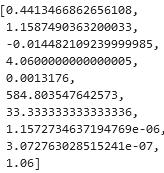

In [ ]:
Largest differences:
    
# I1
a4: 4.06    -> 2.64  (factor 1.54)
a5: 0.001   -> 0.0004

# I2
a6: 584     -> 291

# I3
a8: 1.15e-6 -> 6.49e-6
a9: 3.07e-7 -> 1.85e-6

In [37]:
# Water [g/kg]
print(6.49e-6/1.15e-6)

# Ice [g/kg]
print(1.85e-6/3.07e-7)

5.643478260869565
6.026058631921825


**Another great set of parameters**

In [41]:
# Best TL2 coefficients from home/b/b309170/my_work/published_code/grundner23james_EquationDiscovery_CloudCover_addressing_reviews/sec5_results/sec53_transferability_to_era5/era5_1979-2021/era5_tuned_pysr_EQ4_mod.json
# In normalized space
[a, b, c, d, e, f, g, h, i, j] = [50.818449950078175, 43.23563288907758, 8.086596264765483, 0.0018823345059999037, 0.012696359778781446, \
                                  0.3402846000942713, 31.658641081563403, 9.883877885128662, 0.3907057858581737, 0.6398516948067148]

In [42]:
# Where did those numbers come from (from mo_cover.f90)?

# ! ! These were tuned on ERA5 data and yield worse results online:
# ! ! Ensure dC/dRH >= 0 
# ! rh_norm = max(rh_norm, 1/(2.*6.465638378846791*2.261470694652524)*(-6.465638378846791*T_norm**2-39.00553647200795))
# ! !
# ! ! Compute the three terms in the equation
# ! I1 = 39.00553647200795*rh_norm - 42.03463110460265*T_norm + 6.465638378846791*rh_norm*(2.261470694652524*rh_norm + T_norm**2) + 31.168968461162308
# ! I2 = rh_z_norm**2*(0.04262325503419716*rh_z_norm + 0.502986898449626)
# ! I3 = 11.400469972670322/(qc_norm + 0.6233673793100785*qi_norm + 0.7307425434498263)

In [43]:
# Convert to physical form first!

all_possible_features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
            'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']

loc = {}

# Careful here; don't call i_loop just i!!! 
for i_loop in range(len(all_possible_features)):
    loc[all_possible_features[i_loop]] = i_loop
    
# Features
features = ['rh', 'ta', 'clw', 'cli', 'rh_z']
no_features = len(features)

# mean and std
mean_all = [4.12205844e-03,2.25493498e-05,3.38180032e-06,2.57065512e+02,6.00030443e+04,5.64080139e+03,2.35046400e-01,1.32776682e+01,6.02512234e-01,9.86270417e+04,-1.27545273e-06,-4.02484958e-10,1.65204582e-08,-4.34660202e-11,4.29441131e-10,-1.82817316e-12,-4.68742483e-03,-7.54899040e-07,-7.51544542e+00,-1.06989723e-04,1.65615172e-03,-9.27604679e-06,-4.76200071e-05,-1.32246548e-07]
std_all = [5.07648249e-03,5.69702638e-05,1.01308124e-05,3.00533874e+01,3.12514292e+04,5.66963918e+03,4.11184302e-01,1.11389888e+01,3.32494615e-01,6.24039256e+03,2.03179260e-06,1.17041141e-08,1.33311867e-07,1.42840744e-09,6.73384546e-09,5.07424672e-11,5.82875686e-03,6.34826092e-05,3.53136052e+00,1.13215264e-02,6.62892130e-03,6.08144307e-05,2.58065098e-04,2.49552692e-06]

mean = np.concatenate([np.expand_dims(mean_all[loc[sel_var]], axis=0) for sel_var in features], axis = 0)
std = np.concatenate([np.expand_dims(std_all[loc[sel_var]], axis=0) for sel_var in features], axis = 0)

# Introduce variables
# a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r = sp.symbols('a b c d e f g h i j k l m n o p q r')
# x0, x1, x2, x3, x4 = sp.symbols('x0 x1 x2 x3 x4')
rh, ta, clw, cli, rh_z = sp.symbols('rh ta clw cli rh_z')

X0 = (rh - mean[0])/std[0]
X1 = (ta - mean[1])/std[1]
X2 = (clw - mean[2])/std[2]
X3 = (cli - mean[3])/std[3]
X4 = (rh_z - mean[4])/std[4]

I1 = a*X0 - b*X1 + c*X0*(d*X0 + X1**2) + g
I2 = X4**2*(e*X4 + f)
I3 = -h/(X2 + i*X3 + j)

print('I1')
print(sp.expand(I1))

print('\nI2')
print(I2)

print('\nI3')
print(I3)

I1
0.137687125262507*rh**2 + 0.0269273915621086*rh*ta**2 - 13.8442073974759*rh*ta + 1932.10813385435*rh - 0.0162240828458788*ta**2 + 6.90267671696555*ta - 762.68858713935

I2
15015557.2872681*(rh_z + 4.76200071e-5)**2*(49.198283212949*rh_z + 0.34262742269018)

I3
-9.88387788512866/(38566.0863543553*cli + 17553.0168424461*clw + 0.113619774806799)


In [44]:
# Translate the coefficients of these I1, I2, I3 into the old form
a1 = 0.137687125262507
a2 = 0.0269273915621086
a3 = 0.0162240828458788
a4 = 13.8442073974759
a5 = 1932.10813385435
a6 = 6.90267671696555
a7 = 762.68858713935
a8 = 49.198283212949*15015557.2872681
a9 = 0.34262742269018*15015557.2872681
a10 = 17553.0168424461/9.88387788512866
a11 = 38566.0863543553/9.88387788512866
eps = 0.113619774806799/9.88387788512866

old_coef_form = [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, eps]

In [45]:
# Great method to convert from old formulation to the new one!
def convert_coefficients(coefs):
    '''
        Convert 12 original coefficients into 10 new coefficients (all in physical space!).
    '''
    [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, eps] = coefs

    T0 = 257.06
    R0 = 0.6025
    
    # We call the new coefficients b_i in this method
    b5 = 2/100*a2
    b4 = 2/100*a1
    b3 = a6/100 - b5*T0*R0
    b2 = a5/100 + b4*R0 - b5/2*T0**2
    b1 = -a7/100 + b2*R0 + b3*T0 - (b4/2)*R0**2 + (b5/2)*T0**2*R0
    
    b6 = ((a8/100)**(1/3))
    b7 = (0.1*a8/a9)
    b8 = (1/(100*a10))
    b9 = (1/(100*a11))
    eps_new = (100*eps)
    
    return [b1, b2, b3, b4, b5, b6, b7, b8, b9, eps_new]

convert_coefficients(old_coef_form)

[0.31732444967059337,
 1.5291622386019519,
 -0.014382793893559925,
 0.0027537425052501403,
 0.000538547831242172,
 194.75881995222122,
 14.359120127239912,
 5.630871304827673e-06,
 2.5628418176303922e-06,
 1.1495465254356487]